In [1]:
%cd ..\..

C:\Users\rick\source\repos\Modern-Time-Series-Forecasting-with-Python


In [38]:
import pandas as pd

DATA_PATH = "data\stock_prices\SPY US Equity#PX_LAST.csv"
df = pd.read_csv(DATA_PATH, skiprows=1, names=["date", "price"], parse_dates=True, index_col='date')
df.head()

#df["date"]

df_train = df[:pd.Timestamp('2022-12-31')]
df_test = df[pd.Timestamp('2023-01-01'):pd.Timestamp('2023-12-31')]


In [39]:
from darts import TimeSeries

ts_train = TimeSeries.from_dataframe(df_train)
ts_test = TimeSeries.from_dataframe(df_test)

In [40]:
ts_train

<TimeSeries (DataArray) (date: 5014, component: 1, sample: 1)>
array([[[105.27]],

       [[104.99]],

       [[105.41]],

       ...,

       [[376.66]],

       [[383.44]],

       [[382.43]]])
Coordinates:
  * date       (date) datetime64[ns] 2003-10-14 2003-10-15 ... 2022-12-30
  * component  (component) object 'price'
Dimensions without coordinates: sample

In [5]:
ts_test

<TimeSeries (DataArray) (date: 15, component: 1, sample: 1)>
array([[[475.31]],

       [[472.65]],

       [[468.79]],

       [[467.28]],

       [[467.92]],

       [[474.6 ]],

       [[473.88]],

       [[476.56]],

       [[476.35]],

       [[476.68]],

       [[476.68]],

       [[474.93]],

       [[472.29]],

       [[476.49]],

       [[482.43]]])
Coordinates:
  * date       (date) datetime64[ns] 2024-01-01 2024-01-02 ... 2024-01-19
  * component  (component) object 'price'
Dimensions without coordinates: sample

In [41]:
from darts.metrics import mase, mse, mae
from src.utils.ts_utils import forecast_bias

def eval_model(model, ts_train, ts_test, name=None):
    if name is None:
        name = type(model).__name__
    model.fit(ts_train)
    y_pred = model.predict(len(ts_test))
    return y_pred, {
        "Algorithm": name,
        "MAE": mae(actual_series = ts_test, pred_series = y_pred),
        "MSE": mse(actual_series = ts_test, pred_series = y_pred),
        "MASE": mase(actual_series = ts_test, pred_series = y_pred, insample=ts_train),
        "Forecast Bias": forecast_bias(actual_series = ts_test, pred_series = y_pred)
    }


In [42]:
def format_y_pred(y_pred, name):
    y_pred = y_pred.data_array().to_series()
    y_pred.index = y_pred.index.get_level_values(0)
    y_pred.name = name
    return y_pred

In [43]:
from itertools import cycle
import plotly.express as px
import plotly.graph_objects as go

def plot_forecast(pred_df, forecast_columns, forecast_display_names=None):
    if forecast_display_names is None:
        forecast_display_names = forecast_columns
    else:
        assert len(forecast_columns)==len(forecast_display_names)
    mask = ~pred_df[forecast_columns[0]].isnull()
    # colors = ["rgba("+",".join([str(c) for c in plotting_utils.hex_to_rgb(c)])+",<alpha>)" for c in px.colors.qualitative.Plotly]
    colors = [c.replace("rgb", "rgba").replace(")", ", <alpha>)") for c in px.colors.qualitative.Dark2]
    # colors = [c.replace("rgb", "rgba").replace(")", ", <alpha>)") for c in px.colors.qualitative.Safe]
    act_color = colors[0]
    colors = cycle(colors[1:])
    dash_types = cycle(["dash","dot","dashdot"])
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=pred_df[mask].index, y=pred_df[mask].price,
                        mode='lines', line = dict(color=act_color.replace("<alpha>", "0.3")),
                        name='Price'))
    for col, display_col in zip(forecast_columns,forecast_display_names):
        fig.add_trace(go.Scatter(x=pred_df[mask].index, y=pred_df.loc[mask, col],
                            mode='lines', line = dict(dash=next(dash_types), color=next(colors).replace("<alpha>", "1")),
                            name=display_col))
    return fig

In [44]:
def format_plot(fig, legends = None, xlabel="Time", ylabel="Value", title="", font_size=15):
    if legends:
        names = cycle(legends)
        fig.for_each_trace(lambda t:  t.update(name = next(names)))
    fig.update_layout(
            autosize=False,
            width=900,
            height=500,
            title_text=title,
            title={
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
            titlefont={
                "size": 20
            },
            legend_title = None,
            legend=dict(
                font=dict(size=font_size),
                orientation="h",
                yanchor="bottom",
                y=0.98,
                xanchor="right",
                x=1,
            ),
            yaxis=dict(
                title_text=ylabel,
                titlefont=dict(size=font_size),
                tickfont=dict(size=font_size),
            ),
            xaxis=dict(
                title_text=xlabel,
                titlefont=dict(size=font_size),
                tickfont=dict(size=font_size),
            )
        )
    return fig

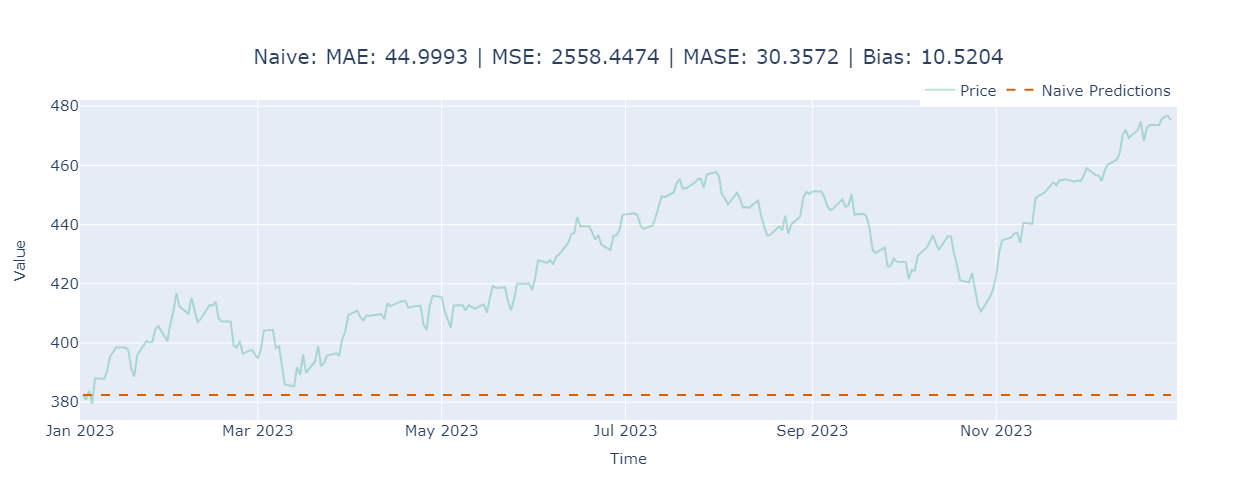

In [47]:
from darts.models import NaiveSeasonal

pred_df = pd.DataFrame(df)

naive_model = NaiveSeasonal(K=1)
y_pred, metrics = eval_model(naive_model, ts_train, ts_test)

y_pred = format_y_pred(y_pred, "naive_predictions")
pred_df = pred_df.join(y_pred)

pred_df = pred_df.dropna()

#pred_df.plot(figsize=(12,5))

fig = plot_forecast(pred_df, forecast_columns=["naive_predictions"], forecast_display_names=['Naive Predictions'])
fig = format_plot(fig, title=f"Naive: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f} | Bias: {metrics['Forecast Bias']:.4f}")
fig.update_xaxes(type="date", range=["2023-01-01", "2023-12-31"])
#fig.write_image("imgs/chapter_4/naive.png")
fig.show()

In [52]:
from darts.models import NaiveMovingAverage
#from src.forecasting.baselines import NaiveMovingAverage

name = "Moving Average Forecast"
naive_model = NaiveMovingAverage(window=48)
with LogTime() as timer:
    y_pred, metrics = eval_model(naive_model, ts_train, ts_val, name=name)
metrics['Time Elapsed'] = timer.elapsed
metric_record.append(metrics)
y_pred = format_y_pred(y_pred, "moving_average_predictions")
pred_df = pred_df.join(y_pred)

ImportError: cannot import name 'NaiveMovingAverage' from 'darts.models' (C:\Users\rick\AppData\Local\anaconda3\envs\modern_ts\lib\site-packages\darts\models\__init__.py)

In [ ]:
fig = plot_forecast(pred_df, forecast_columns=["moving_average_predictions"], forecast_display_names=['Moving Average Predictions'])
fig = format_plot(fig, title=f"Moving Average: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f} | Bias: {metrics['Forecast Bias']:.4f}")
fig.update_xaxes(type="date", range=["2014-01-01", "2014-01-08"])
# fig.write_image("imgs/chapter_4/ma.png")
fig.show()